# Data exploration

here we import a series of needed modules.

In [29]:
import scifAI
import matplotlib.pyplot as plt
from scifAI.ml import features
from scifAI.ml import AutoFeatureSelection
from scifAI.ml import FeatureExtractor 
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import h5py
from sklearn.pipeline import  FeatureUnion, Pipeline
from sklearn.feature_extraction import DictVectorizer
from scifAI.utils import list_of_dict_to_dict
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns


In [30]:
set_of_interesting_classes = ['B_cell', 
                              'T_cell', 
                              'T_cell_with_signaling',
                              'B_T_cell_in_one_layer',
                              'T_cell_with_B_cell_fragments', 
                              'Synapses_without_signaling',
                              'Synapses_with_signaling',
                              'No_cell_cell_interaction',
                              'Multiplets', ] 

now lets calculate the metadata:

In [31]:
metadata = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_subset_with_predictions.csv.gz")
df_features = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/df_features_subset.csv.gz")


In [32]:
print(metadata.shape, df_features.shape)

(1065967, 12) (1065967, 1247)


In [33]:
metadata.head()

,file,experiment,donor,condition,object_number,set,label,prediction,entropy,key,outlier,cluster
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,5156,unlabeled,-1,B_cell,0.001350,Experiment_1 Donor_1,False,0
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,32020,unlabeled,-1,T_cell,0.000959,Experiment_1 Donor_1,False,1
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,55974,unlabeled,-1,Dead_Cell,0.002358,Experiment_1 Donor_1,False,0
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,15150,unlabeled,-1,T_cell,0.000502,Experiment_1 Donor_1,False,1
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,44814,unlabeled,-1,B_cell_with_small_area,0.028317,Experiment_1 Donor_1,False,2


In [34]:

selected_feature_names = ['mask_based_major_axis_length_MHCII',
       'mask_based_major_axis_length_CD3', 'correlation_F-Actin',
       'contrast_P-CD3zeta', 'homogeneity_F-Actin', 'ASM_CD3',
       'mean_intensity_ratio_F-Actin_R5_R6',
       'max_intensity_ratio_MHCII_R5_R6', 'mask_based_solidity_F-Actin',
       'max_intensity_ratio_F-Actin_R5_R6',
       'mask_based_equivalent_diameter_BF', 'dissimilarity_F-Actin',
       'mask_based_eccentricity_CD3',
       'mean_intensity_ratio_P-CD3zeta_R5_R6', 'correlation_CD3',
       'manders_overlap_coefficient_R5_MHCII_R7_P-CD3zeta',
       'correlation_P-CD3zeta', 'mask_based_solidity_P-CD3zeta',
       'mean_intensity_P-CD3zeta', 'skew_intensity_P-CD3zeta',
       'correlation_distance_R5_MHCII_R6_CD3', 'dissimilarity_P-CD3zeta',
       'contrast_CD3', 'sum_intensity_CD3',
       'sum_intensity_ratio_MHCII_R5_R6', 'mask_based_eccentricity_BF',
       'homogeneity_BF', 'mask_based_solidity_CD3', 'mask_based_area_CD3',
       'kurtosis_intensity_P-CD3zeta', 'mean_intensity_CD3',
       'skew_intensity_MHCII', 'mask_based_feret_diameter_max_BF',
       'correlation_MHCII', 'mask_based_major_axis_length_P-CD3zeta',
       'mask_based_bbox_area_CD3', 'mean_intensity_ratio_CD3_R5_R6',
       'manders_overlap_coefficient_R5_MHCII_R6_CD3',
       'mean_intensity_ratio_MHCII_R5_R6',
       'mask_based_feret_diameter_max_CD3', 'kurtosis_intensity_CD3',
       'homogeneity_CD3', 'sum_intensity_ratio_CD3_R5_R6',
       'mask_based_eccentricity_F-Actin',
       'structural_similarity_R4_F-Actin_R5_MHCII',
       'max_intensity_ratio_P-CD3zeta_R5_R6', 'mask_based_solidity_MHCII',
       'mean_intensity_F-Actin', 'homogeneity_MHCII',
       'mean_intensity_MHCII', 'contrast_MHCII', 'dissimilarity_MHCII',
       'dissimilarity_CD3', 'skew_intensity_F-Actin',
       'mask_based_extent_BF', 'max_intensity_ratio_CD3_R5_R6',
       'mask_based_major_axis_length_F-Actin',
       'euclidean_distance_R5_MHCII_R6_CD3', 'std_intensity_P-CD3zeta',
       'mask_based_eccentricity_MHCII', 'dice_distance_BF_CD3',
       'intensity_correlation_quotient_R5_MHCII_R6_CD3',
       'mask_based_eccentricity_P-CD3zeta', 'skew_intensity_CD3',
       'sum_intensity_F-Actin', 'correlation_BF']

In [35]:
metadata.outlier.astype(str).unique()

array(['False', '1'], dtype=object)

In [36]:
from sklearn.model_selection import train_test_split

metadata["key"] = metadata["experiment"] + "_" + metadata["donor"] + "_" + metadata["condition"]
indx = metadata.outlier.astype(str) == "False"
indx = indx & metadata.prediction.isin(set_of_interesting_classes)
_,indx,_,_ = train_test_split(metadata.loc[indx,:].index, metadata.loc[indx,"key"], test_size = 0.01, stratify=metadata.loc[indx,"key"])

indx = indx.tolist()
indx = sorted(indx)

In [37]:
metadata.loc[indx, "outlier"].astype(str).unique()

array(['False'], dtype=object)

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

X_transformed = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(df_features.loc[indx, selected_feature_names]))


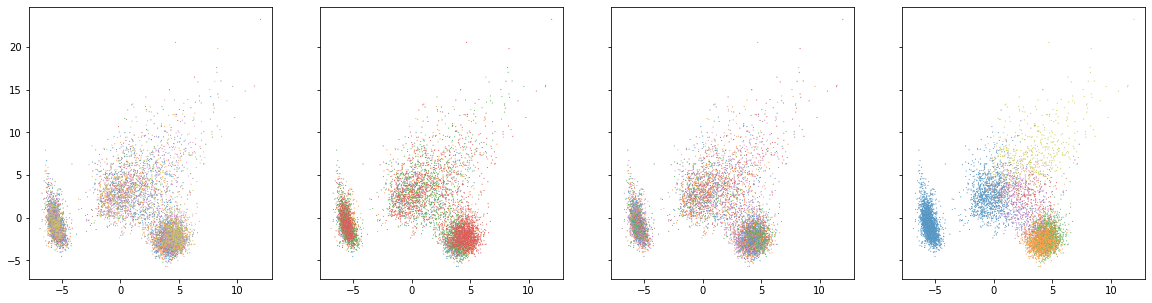

In [39]:
fig , ax = plt.subplots(nrows=1, ncols = 4, figsize = (20,5) , sharex=True, sharey=True)


ax[0] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"donor"],
                     s = 1, 
                     ax = ax[0] ) 
ax[0].legend().remove()

ax[1] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"experiment"],
                     s = 1, 
                     ax = ax[1] ) 
ax[1].legend().remove()

ax[2] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"condition"],
                        hue_order = ["-SEA","+SEA", "DIG-TCB", "CD19-TCB", "CD20-TCB", "Isotype", "Teplizumab"],
                     s = 1, 
                     ax = ax[2] ) 
ax[2].legend().remove()

ax[3] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"prediction"],
                     s = 1,  
                        hue_order = set_of_interesting_classes,
                     ax = ax[3] ) 
ax[3].legend().remove()

plt.savefig('Supplementary Figure - PCA of data without legends.png', bbox_inches="tight")

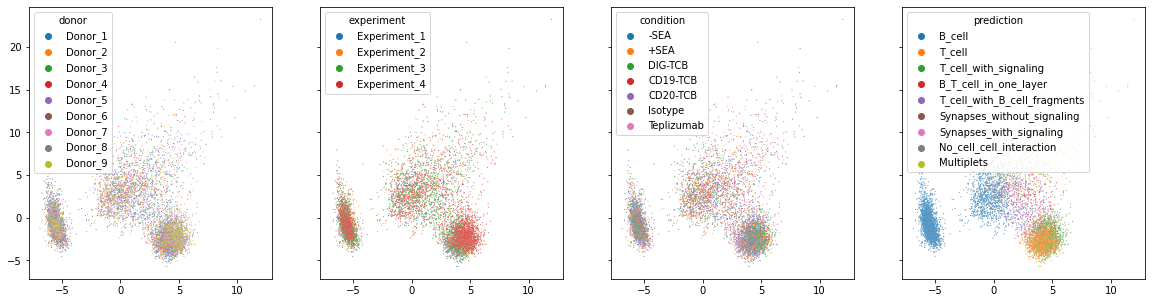

In [40]:
fig , ax = plt.subplots(nrows=1, ncols = 4, figsize = (20,5) , sharex=True, sharey=True)


ax[0] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"donor"],
                     s = 1, 
                     ax = ax[0] ) 

ax[1] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"experiment"],
                     s = 1, 
                     ax = ax[1] ) 

ax[2] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"condition"],
                        hue_order = ["-SEA","+SEA", "DIG-TCB", "CD19-TCB", "CD20-TCB", "Isotype", "Teplizumab"],
                     s = 1, 
                     ax = ax[2] ) 

ax[3] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"prediction"],
                     s = 1, 
                        hue_order = set_of_interesting_classes,
                     ax = ax[3] ) 

plt.savefig('Supplementary Figure - PCA of data with legends.png', bbox_inches="tight")

In [41]:
np.array(sns.color_palette( "colorblind" ))

array([[0.00392157, 0.45098039, 0.69803922],
       [0.87058824, 0.56078431, 0.01960784],
       [0.00784314, 0.61960784, 0.45098039],
       [0.83529412, 0.36862745, 0.        ],
       [0.8       , 0.47058824, 0.7372549 ],
       [0.79215686, 0.56862745, 0.38039216],
       [0.98431373, 0.68627451, 0.89411765],
       [0.58039216, 0.58039216, 0.58039216],
       [0.9254902 , 0.88235294, 0.2       ],
       [0.3372549 , 0.70588235, 0.91372549]])

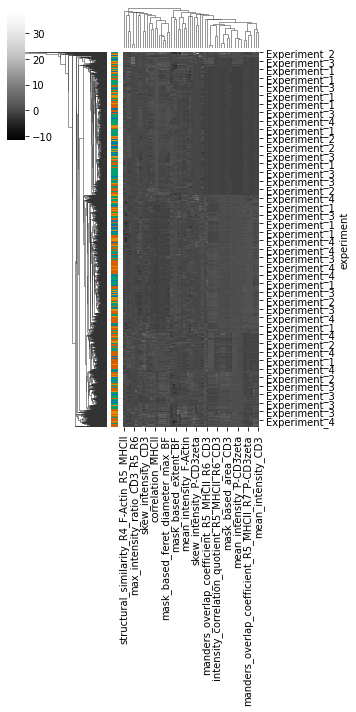

In [42]:
df_heatmap = StandardScaler().fit_transform(df_features.loc[indx, selected_feature_names])
df_heatmap = pd.DataFrame(df_heatmap, columns = selected_feature_names, index = metadata.loc[indx,"experiment"])


color_scheme = {"Experiment_1":[0.00392157, 0.45098039, 0.69803922],
               "Experiment_2":[0.87058824, 0.56078431, 0.01960784],
               "Experiment_3":[0.00784314, 0.61960784, 0.45098039],
               "Experiment_4":[0.83529412, 0.36862745, 0.        ]}
row_colors = metadata.loc[indx,"experiment"].tolist()
row_colors = [color_scheme[ex] for ex in row_colors]


sns.clustermap(df_heatmap, cmap="Greys_r", row_colors=row_colors, figsize=(5, 10), dendrogram_ratio=(0.4, 0.1))

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA 

X_transformed = KernelPCA(n_components=2, kernel="cosine").fit_transform(StandardScaler().fit_transform(df_features.loc[indx, selected_feature_names]))


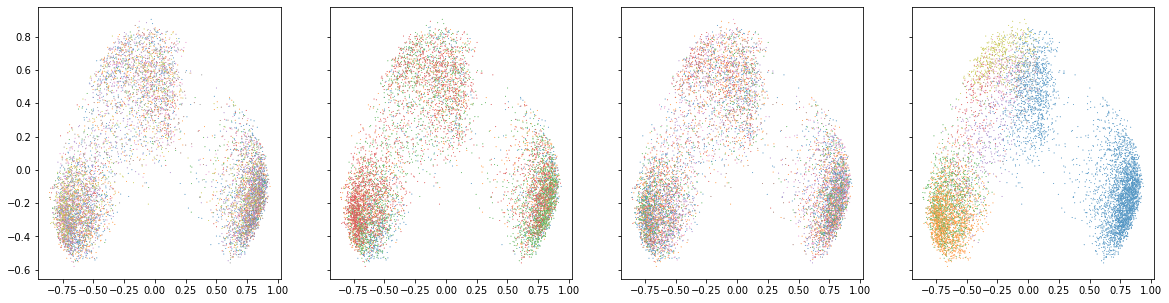

In [44]:
fig , ax = plt.subplots(nrows=1, ncols = 4, figsize = (20,5) , sharex=True, sharey=True)


ax[0] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"donor"],
                     s = 1, 
                     ax = ax[0] ) 
ax[0].legend().remove()

ax[1] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"experiment"],
                     s = 1, 
                     ax = ax[1] ) 
ax[1].legend().remove()

ax[2] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"condition"],
                        hue_order = ["-SEA","+SEA", "DIG-TCB", "CD19-TCB", "CD20-TCB", "Isotype", "Teplizumab"],
                     s = 1, 
                     ax = ax[2] ) 
ax[2].legend().remove()

ax[3] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"prediction"],
                     s = 1,  
                        hue_order = set_of_interesting_classes,
                     ax = ax[3] ) 
ax[3].legend().remove()

plt.savefig('Supplementary Figure - kernel PCA of data without legends.png', bbox_inches="tight")

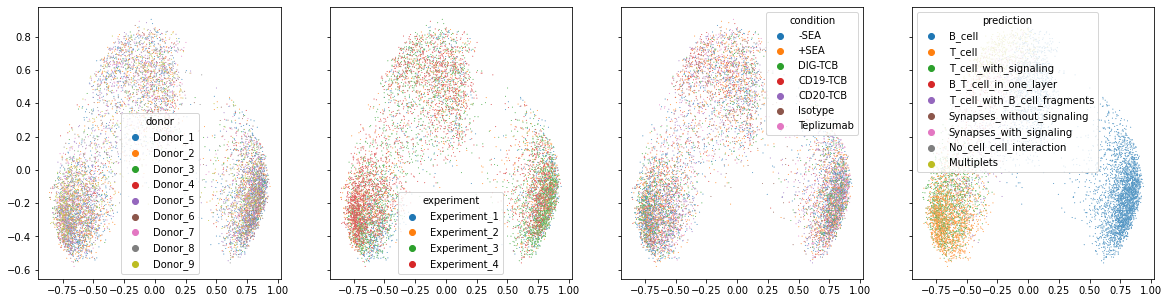

In [45]:
fig , ax = plt.subplots(nrows=1, ncols = 4, figsize = (20,5) , sharex=True, sharey=True)


ax[0] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"donor"],
                     s = 1, 
                     ax = ax[0] ) 

ax[1] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"experiment"],
                     s = 1, 
                     ax = ax[1] ) 

ax[2] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"condition"],
                        hue_order = ["-SEA","+SEA", "DIG-TCB", "CD19-TCB", "CD20-TCB", "Isotype", "Teplizumab"],
                     s = 1, 
                     ax = ax[2] ) 

ax[3] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"prediction"],
                     s = 1, 
                        hue_order = set_of_interesting_classes,
                     ax = ax[3] ) 

plt.savefig('Supplementary Figure - kernel PCA of data with legends.png', bbox_inches="tight")

In [46]:
from umap import UMAP 

X_transformed = UMAP(n_components=2, n_jobs=-1, random_state=314).fit_transform(StandardScaler().fit_transform(df_features.loc[indx, selected_feature_names]))


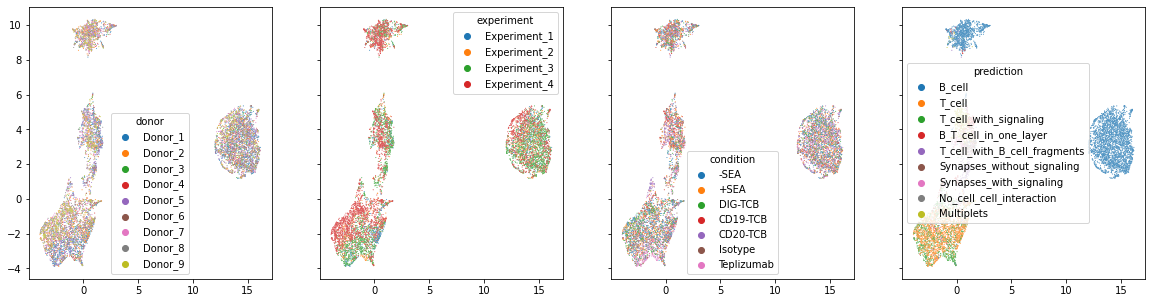

In [47]:
fig , ax = plt.subplots(nrows=1, ncols = 4, figsize = (20,5) , sharex=True, sharey=True)


ax[0] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"donor"],
                     s = 1, 
                     ax = ax[0] ) 
# ax[0].legend().remove()

ax[1] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"experiment"],
                     s = 1, 
                     ax = ax[1] ) 
# ax[1].legend().remove()

ax[2] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"condition"],
                    hue_order = ["-SEA","+SEA", "DIG-TCB", "CD19-TCB", "CD20-TCB", "Isotype", "Teplizumab"],
                     s = 1, 
                     ax = ax[2] ) 
# ax[2].legend().remove()

ax[3] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"prediction"],
                     s = 1,  
                        hue_order = set_of_interesting_classes,
                     ax = ax[3] ) 

plt.savefig('Supplementary Figure - umap of data with legends.png', bbox_inches="tight")

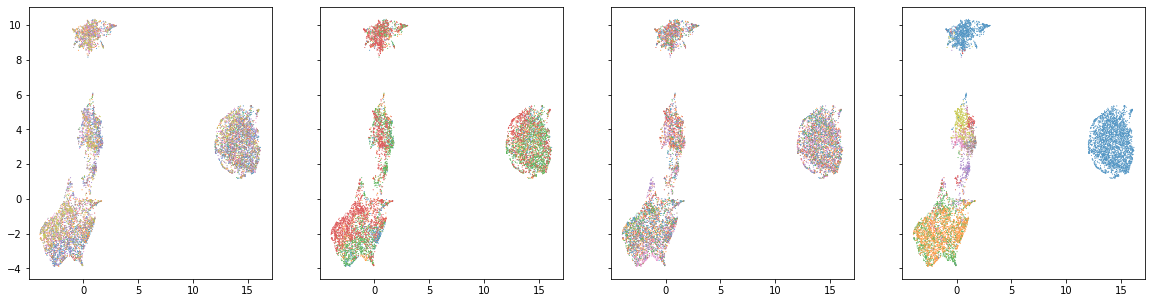

In [48]:
fig , ax = plt.subplots(nrows=1, ncols = 4, figsize = (20,5) , sharex=True, sharey=True)


ax[0] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"donor"],
                     s = 1, 
                     ax = ax[0] ) 
ax[0].legend().remove()

ax[1] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"experiment"],
                     s = 1, 
                     ax = ax[1] ) 
ax[1].legend().remove()

ax[2] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"condition"],
                    hue_order = ["-SEA","+SEA", "DIG-TCB", "CD19-TCB", "CD20-TCB", "Isotype", "Teplizumab"],
                     s = 1, 
                     ax = ax[2] ) 
ax[2].legend().remove()

ax[3] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                    hue = metadata.loc[indx,"prediction"],
                     s = 1,  
                        hue_order = set_of_interesting_classes,
                     ax = ax[3] ) 
ax[3].legend().remove()

plt.savefig('Supplementary Figure - umap of data without legends.png', bbox_inches="tight")